The goal here is to evaluate the errors introduced adversarial training by a analyzing the added noise

In [13]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import normaltest, anderson, shapiro

In [14]:
origWeights = np.load('origWeights.npy', allow_pickle=True)
modifiedWeights = np.load('modifiedWeights.npy', allow_pickle=True)
origBiases = np.load('origBiases.npy', allow_pickle=True)
modifiedBiases = np.load('modifiedBiases.npy', allow_pickle=True)

In [15]:
def compute_minAndMax(listArrays):
    '''
    Function to find the smallest and largest elements 
    in a list of numpy arrays
    '''
    minVal = np.inf
    maxVal = -np.inf
    for arr in listArrays:
        if arr.min() < minVal:
            minVal = arr.min()
        if arr.max() > maxVal:
            maxVal = arr.max()
    return minVal, maxVal

In [16]:
def measure_noise(origValues, modifiedValues):
    noiseValues = []
    for origArr, modifiedArr in zip(origValues, modifiedValues):
        # error_arr is the element-wise difference of all values in the array
        errorArr = origArr - modifiedArr
        noiseValues.append(errorArr)
    return noiseValues

In [17]:
# The CNN for MNIST and the CNN for CIFAR-10, both have convolutional layers followed by a dense layer and then
# a softmax layer. So, the number of conv layers is 2 less than the total number of layers.
numConvLayers = len(origWeights) - 2
modelNoise = measure_noise(origWeights, modifiedWeights)
modelNoiseConvLayers = modelNoise[:numConvLayers]

In [18]:
for layer in modelNoiseConvLayers:
    print(layer.T.shape)
colors = []
if numConvLayers == 3:
    palette = ['r', 'g', 'b']
else:
    palette = ['r', 'g', 'b', 'y', 'c']

# Create a array of colors representing the layers to which the various 9*1 vectors belong to.
for layer,c in zip(modelNoiseConvLayers, palette):
    for kernel in layer.T:
        for matrix in kernel:
            colors.append(c)

(32, 3, 3, 3)
(32, 32, 3, 3)
(64, 32, 3, 3)
(64, 64, 3, 3)
(128, 64, 3, 3)


In [19]:
def generate_GaussianNoise(noise):
    """ Generate Gaussian noise with the same shape and range as noise. The mean of the generated noise is always 
    0, and the standard deviation is chosen as range/6. This is based on the fact that 99.7% of the values in 
    a Gaussian distribution are within a 6*sigma width around the mean. This makes the range of the generated 
    Gaussian noise approximates same as the range of noise."""
    randNoise = []
    minNoise, maxNoise = compute_minAndMax(noise)
    sigma = (maxNoise - minNoise)/6
    for layer in noise:
        randLayer = np.random.normal(0, sigma, layer.shape)
        randNoise.append(randLayer)
    return randNoise

In [21]:
def flatten_listArrays(listArrays):
    flattenedArray = np.array([])
    for array in listArrays:
        flattenedArray = np.append(flattenedArray, array.flatten())
    return flattenedArray

In [278]:
minNoise, maxNoise = compute_minAndMax(modelNoise)
sigma = (maxNoise - minNoise)/6
print(sigma)

0.008169320722421011


In [294]:
# Generate the Gaussian noise
for i in range(50):
    randNoise = generate_GaussianNoise(modelNoise)
    randNoiseConvLayers = randNoise[:numConvLayers]
    # Check if it follows a Gaussian distribution
    randNoise1D = flatten_listArrays(randNoise)
    _, p = normaltest(randNoise1D)
    print('%.3f' % p, end=' ')

0.359 0.289 0.518 0.350 0.624 0.921 0.594 0.616 0.636 0.912 0.853 0.932 0.071 0.112 0.836 0.932 0.374 0.480 0.166 0.314 0.776 0.305 0.887 0.298 0.912 0.518 0.751 0.796 0.591 0.145 0.715 0.895 0.569 0.516 0.798 0.129 0.242 0.297 0.320 0.237 0.759 0.446 0.210 0.565 0.775 0.552 0.920 0.480 0.063 0.904 

In [22]:
# Compute random noise for all of the layers in the same shape as the neural network weights.
def compute_realNoise(modelNoise, randNoise, k = 0.01):
    """ Generates real noise consisting of model noise with varying amounts of random noise. The generated noise 
    has the same shape as the input model noise. Both modelNoise and randNoise are expected to have the same 
    length """
    realNoise = []
    randNoiseArray = []
    for modelLayer, randLayer in zip(modelNoise, randNoise):
        realLayer = modelLayer + k*randLayer
        realNoise.append(realLayer)
        randNoiseArray.append(k*randLayer)
    variance = np.var(flatten_listArrays(randNoiseArray))
    return realNoise, variance

variance of model noise : 3.9250516633536824e-07
variance = 6.68e-07
p=0.000
variance = 6.02e-06
p=0.000
variance = 1.67e-05
p=0.000
variance = 3.28e-05
p=0.000
variance = 5.41e-05
p=0.007
variance = 8.09e-05
p=0.176
variance = 0.000113
p=0.425
variance = 0.00015
p=0.591
variance = 0.000193
p=0.687
variance = 0.000241
p=0.744
variance = 0.000295
p=0.781
variance = 0.000354
p=0.805


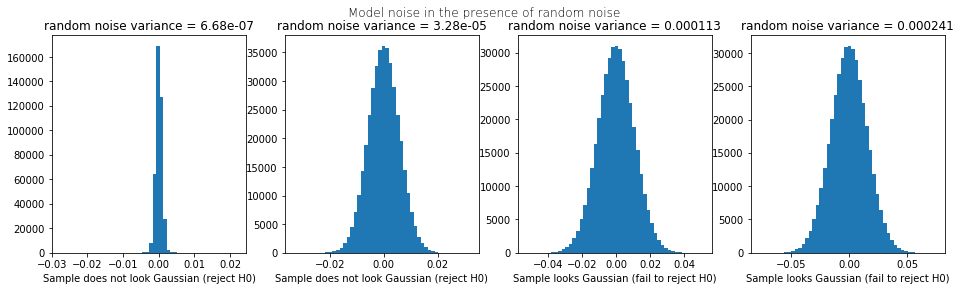

In [295]:
v = np.var(flatten_listArrays(modelNoise))
print('variance of model noise : {}'.format(v))
noiseCoefs = [0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2.1, 2.3]
f, axarr = plt.subplots(1, 4, figsize=(16,4))
f.suptitle('Model noise in the presence of random noise', fontsize=12, fontweight=15)
for idx, k in enumerate(noiseCoefs):
    realNoise, variance = compute_realNoise(modelNoise, randNoise, k)
    realNoise1D = flatten_listArrays(realNoise)
    stat, p = normaltest(realNoise1D)
    print('variance = {0:.3g}'.format(variance))
    print('p=%.3f' % p)
    alpha = 0.05
    if p > alpha:
        txt='Sample looks Gaussian (fail to reject H0)'
    else:
        txt='Sample does not look Gaussian (reject H0)'
    #print(txt)
    if idx%3 == 0:
        pltIdx = idx//3
        axarr[pltIdx].hist(realNoise1D, 50)
        axarr[pltIdx].set(title='random noise variance = {0:.3g}'.format(variance), xlabel = txt)

In [66]:
# Shapiro-Wilk test for purely random noise
randNoise1D = flatten_listArrays(randNoise)
stat, p = shapiro(randNoise1D)

/home/vrabhilash/miniconda3/envs/thesis/lib/python3.7/site-packages/scipy/stats/morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [85]:
randNoise1D = flatten_listArrays(randNoise)


In [251]:
r = np.random.normal(0, 1, 100000)
stat, p = normaltest(r.flatten())
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=6.284, p=0.043
